# **Submission Project Deployment Image (Rock, Paper, Sciccors)**

---


Maisy Amelia Silvani

---


email: maisyamelia@gmail.com

In [13]:
import tensorflow as tf
print("TensorFlow version : ", tf.__version__)

#Prepare the data
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip


TensorFlow version :  2.5.0
--2021-07-23 03:53:31--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  3.76MB/s    in 77s     

2021-07-23 03:54:50 (3.98 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



In [2]:
#Extracting zip data
import zipfile, os 
local_zip = "/tmp/rockpaperscissors.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("/tmp")
zip_ref.close()

#Split train data and validation data using splitfolders
!pip install split-folders


In [18]:
import splitfolders
base_dir = "/tmp/rockpaperscissors/rps-cv-images"
print("Isi direktori /rockpaperscissors/rps-cv-images : ", os.listdir(base_dir)) #isi direktori rps-cv-images
splitfolders.ratio(base_dir, output = "/tmp/rockpaperscissors/", seed = 100, ratio = (.8, .2))
train_dir = os.path.join("/tmp/rockpaperscissors", "train")
validation_dir = os.path.join("/tmp/rockpaperscissors", "val")

#Train & validation data generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, fill_mode = "nearest", validation_split = 0.2)
validation_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, fill_mode = "nearest", validation_split = 0.2)

train_generator = train_datagen.flow_from_directory(base_dir, target_size = (150, 150), class_mode = "sparse", subset = "training")
validation_generator = validation_datagen.flow_from_directory(base_dir, target_size = (150, 150), class_mode = "sparse", subset = "validation")

Copying files: 182 files [00:00, 1819.10 files/s]

Isi direktori /rockpaperscissors/rps-cv-images :  ['README_rpc-cv-images.txt', 'rock', 'paper', 'scissors']


Copying files: 2188 files [00:00, 2274.39 files/s]


Found 1751 images belonging to 3 classes.
Found 437 images belonging to 3 classes.


In [26]:
#Total Image Data
import glob 
total_image = len(list(glob.iglob("/tmp/rockpaperscissors/rps-cv-images/*/*.*", recursive=True)))
print("Data Image Total =", total_image)

Data Image Total = 2188


In [27]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = "relu", input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])



In [30]:
#Using Callbacks
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get("accuracy")>0.92 and logs.get("val_accuracy")>0.92):
      print("Accuracy reach 92% or above. Stop training!")
      self.model.stop_training = True
callbacks = myCallback()

In [31]:
#compile model
model.compile(optimizer=tf.optimizers.Adam(), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
#train model
history = model.fit(train_generator, steps_per_epoch=25, epochs=20, callbacks = [callbacks], validation_data=validation_generator, validation_steps=5, verbose=2)


Epoch 1/20
25/25 - 45s - loss: 0.4964 - accuracy: 0.7987 - val_loss: 0.3337 - val_accuracy: 0.8750
Epoch 2/20
25/25 - 44s - loss: 0.3208 - accuracy: 0.8975 - val_loss: 0.2948 - val_accuracy: 0.9000
Epoch 3/20
25/25 - 44s - loss: 0.3518 - accuracy: 0.8799 - val_loss: 0.3103 - val_accuracy: 0.9000
Epoch 4/20
25/25 - 44s - loss: 0.2292 - accuracy: 0.9254 - val_loss: 0.1506 - val_accuracy: 0.9312
Accuracy reach 92% or above. Stop training!


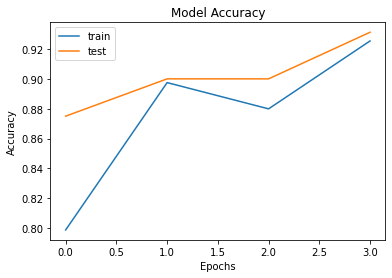

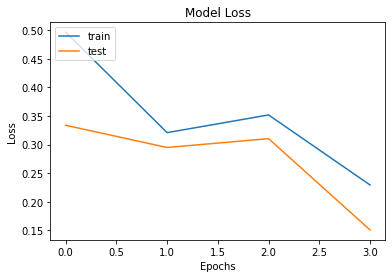

In [32]:
#Accuracy plot
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["train", "test"], loc="upper left")
plt.show()

#Loss plot
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["train", "test"], loc="upper left")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [33]:
#Make sure to also load truncated images
!pip install pillow

In [34]:
#Convert Model to Tf-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpl76rlbfd/assets


In [35]:
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

Saving IMG20210707134452.jpg to IMG20210707134452.jpg
IMG20210707134452.jpg
Scissors-hand...


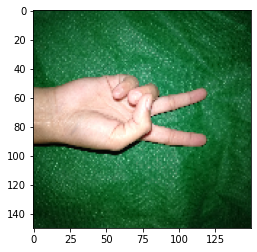

In [36]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


uploaded = files.upload()
for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size = (150, 150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size = 10)
  print(fn)
  if classes[0, 0]!=0:
    print("Oh! that's paper")
  elif classes[0, 1]!=0:
    print("This is rock!")
  else:
    print("Scissors-hand...")

Here is the result after testing the model with my own hand (shooted from Oppo A3S camera with the flash on).